In [16]:
import os
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['XLA_FLAGS'] = xla_flags
# os.environ["MUJOCO_GL"] = "egl"
os.environ['JAX_PLATFORM_NAME'] = 'gpu'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # change to your GPU id
import pickle
from datetime import datetime
from helper import parse_cfg
from omegaconf import OmegaConf
from flax.training import checkpoints

# import mediapy as media
import hydra
import functools
from brax.training.acme import running_statistics
from etils import epath
from omegaconf import OmegaConf
from typing import Any, Callable, Dict, Optional, Type, Union, Tuple
from mujoco import mjx
import numpy
from custom_envs import registry, dm_control_suite, locomotion
import jax
from learning.agents.ppo import networks as ppo_networks
from learning.configs import dm_control_training_config, locomotion_training_config
from custom_envs import mjx_env
import jax.numpy as jnp
import matplotlib.pyplot as plt


In [ ]:

from learning.agents.sampler_ppo.train import _unpmap
from learning.module.wrapper.adv_wrapper import wrap_for_adv_training
from learning.module.wrapper.evaluator import AdvEvaluator


def evaluate(cfg, key):
    num_eval_envs = 4096
    # Load environment
    env = registry.load(cfg.task)
    env_cfg = registry.get_default_config(cfg.task)


    print("env nv", env._mj_model.nv)
    obs_size = env.observation_size
    act_size = env.action_size
    rng = jax.random.PRNGKey(cfg.eval_seed)
    randomizer = registry.get_domain_randomizer_ood(cfg.task) if cfg.ood_setting else registry.get_domain_randomizer_eval(cfg.task)
    v_randomization_fn = functools.partial(
        randomizer,
        dr_range= env.ood_range if cfg.ood_setting else env.dr_range,
    )
    dr_range_low, dr_range_high = env.ood_range if cfg.ood_setting else env.dr_range
    eval_env = wrap_for_adv_training(
        env,
        episode_length=env_cfg.episode_length,
        action_repeat=env_cfg.action_repeat,
        randomization_fn=v_randomization_fn,
        param_size = len(dr_range_low),
        dr_range_low=dr_range_low,
        dr_range_high=dr_range_high,
    )  # pytype: disable=wrong-keyword-args
    

    if "ppo" in cfg.policy:
        if cfg.task in dm_control_suite._envs:
            ppo_params = dm_control_training_config.brax_ppo_config(cfg.task)
        elif cfg.task in locomotion._envs:
            ppo_params = locomotion_training_config.locomotion_ppo_config(cfg.task)
        network_factory = ppo_networks.make_ppo_networks
        if "network_factory" in ppo_params:
            network_factory = functools.partial(
                ppo_networks.make_ppo_networks,
                **ppo_params.network_factory
            )
        ppo_network = network_factory(
            observation_size=obs_size,
            action_size=act_size,
            preprocess_observations_fn=running_statistics.normalize if ppo_params.normalize_observations else None,
        )

        make_policy_fn = ppo_networks.make_inference_fn(ppo_network)
    # Load saved parameters
    save_dir = os.path.join(cfg.work_dir, "models")
    print(f"Loading parameters from {save_dir}")
    with open(os.path.join(save_dir, f"{cfg.policy}_params_latest.pkl"), "rb") as f:
        params = pickle.load(f)
    eval_key, key = jax.random.split(key)
    evaluator = AdvEvaluator(
        eval_env,
        functools.partial(make_policy_fn, deterministic=True),
        num_eval_envs=num_eval_envs,
        episode_length=env_cfg.episode_length,
        action_repeat=env_cfg.action_repeat,
        key=eval_key,
    )
    if len(dr_range_low) >2:
        param_key, key = jax.random.split(key)
        dynamics_params_grid = jax.random.uniform(param_key, shape=(4096, len(dr_range_low)), minval=dr_range_low, maxval=dr_range_high)
        metrics, reward_1d, epi_length = evaluator.run_evaluation(
            params,
            dynamics_params=dynamics_params_grid,
            training_metrics={},
            num_eval_seeds=10,
            success_threshold=0.7,
        )
        return metrics, reward_1d

    elif len(dr_range_low) == 2:
        x, y = jnp.meshgrid(jnp.linspace(dr_range_low[0], dr_range_high[0], 64),\
                              jnp.linspace(dr_range_low[1], dr_range_high[1], 64))
        dynamics_params_grid = jnp.c_[x.ravel(), y.ravel()]
        metrics, reward_1d, epi_length = evaluator.run_evaluation(
            params,
            dynamics_params=dynamics_params_grid,
            training_metrics={},
            num_eval_seeds=10,
            success_threshold=0.7,
        )
        eval_fig = plt.figure()
        reward_2d = reward_1d.reshape(x.shape)
        # vmin, vmax = 0, 1000
        # levels = np.linspace(vmin, vmax, 21)  # 21 levels = 20 color intervals
        ctf = plt.contourf(x, y, reward_2d, levels=20, cmap='viridis')
        cbar = eval_fig.colorbar(ctf)
        eval_fig.suptitle(f"Evaluation on Each Params")
        eval_fig.tight_layout()
        eval_fig.canvas.draw()
        return metrics, reward_2d, eval_fig


/home/sukchul/adverserial_sampler_for_rl/learning
cfg: {'num_envs': 1024, 'batch_size': 1024, 'benchmark': 'dm_control', 'task': 'CheetahRun', 'obs': 'state', 'exp_name': 'test', 'checkpoint': '???', 'impl': 'warp', 'eval_with_training_env': False, 'num_evals': 20, 'policy': 'ppo', 'asymmetric_critic': True, 'distributional_q': False, 'wandb_project': 'gradient_test', 'wandb_entity': 'tjrcjf410-seoul-national-university', 'wandb_silent': False, 'use_wandb': True, 'save_csv': True, 'comment': '', 'randomization': False, 'final_randomization': True, 'custom_wrapper': True, 'dr_train_ratio': 1.0, 'group': '???', 'epsilon': 0.1, 'scheduler_lr': 0.2, 'scheduler_window_size': 20, 'sampler_update_freq': 1, 'n_sampler_iters': 50, 'success_threshold': 0.7, 'success_rate_condition': 0.7, 'gamma': 0.0, 'beta': 1.0, 'use_scheduling': False, 'save_video': True, 'save_agent': True, 'seed': 0, 'work_dir': '???', 'simba': False, 'horizon': 3, 'omega_distance_threshold': 0.1, 'save_dir': './logs/Cheeta

({'eval/walltime': 70.43375277519226,
  'eval/coverage': Array(0.92333984, dtype=float32),
  'eval/episode_reward_mean': Array(871.34503, dtype=float32),
  'eval/episode_reward_p12': np.float32(748.1716),
  'eval/episode_reward_p25': np.float32(844.7915),
  'eval/episode_reward_p75': np.float32(933.2545),
  'eval/episode_reward_std': Array(88.750534, dtype=float32),
  'eval/episode_reward_min': Array(493.14728, dtype=float32),
  'eval/episode_reward_max': Array(945.684, dtype=float32),
  'eval/episode_reward_iqm': np.float32(904.25134),
  'eval/episode_reward_CVaR20': np.float32(714.8863),
  'eval/episode_reward_CVaR10': np.float32(658.25977),
  'eval/avg_episode_length': Array(1000., dtype=float32),
  'eval/std_episode_length': Array(0., dtype=float32),
  'eval/epoch_eval_time': 70.43375277519226,
  'eval/sps': 58153.93669386686},
 Array([[606.44794, 572.8175 , 602.77356, ..., 560.78217, 535.07965,
         545.49207],
        [637.52374, 631.75165, 637.19586, ..., 519.08295, 529.1684

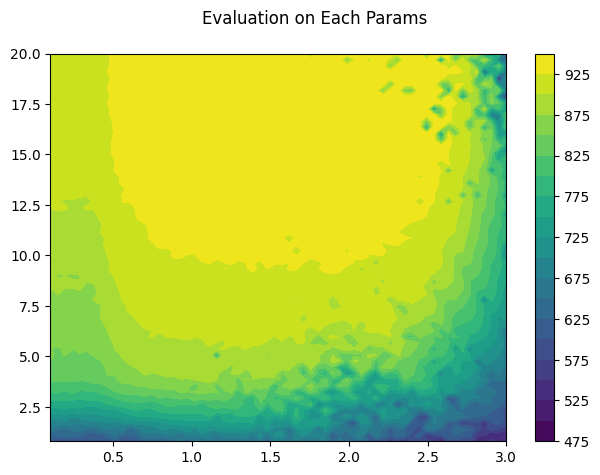

In [18]:

cfg_path= epath.Path(".").resolve()
print(cfg_path)
cfg_path = os.path.join(cfg_path, "config.yaml")
# cfg = compose(config_name="config.yaml")
cfg = OmegaConf.load(cfg_path)
cfg.task="CheetahRun"
cfg.policy="ppo"
cfg.seed=0
cfg.save_dir = f"./logs/{cfg.task}/{cfg.seed}/{cfg.policy}"
cfg.randomization=False

print("cfg:", cfg)
cfg = parse_cfg(cfg)
cfg.eval_seed= 55
print("work dir", cfg.work_dir)

evaluate(cfg, jax.random.PRNGKey(cfg.eval_seed))


In [21]:

cfg_path= epath.Path(".").resolve()
print(cfg_path)
cfg_path = os.path.join(cfg_path, "config.yaml")
# cfg = compose(config_name="config.yaml")
cfg = OmegaConf.load(cfg_path)
cfg.task="CheetahRun"
cfg.policy="gmmppo"
cfg.seed=2
cfg.save_dir = f"./logs/{cfg.task}/{cfg.seed}/{cfg.policy}"
cfg.randomization=False

print("cfg:", cfg)
cfg = parse_cfg(cfg)
cfg.eval_seed= 55
print("work dir", cfg.work_dir)

evaluate(cfg, jax.random.PRNGKey(cfg.eval_seed))


/home/sukchul/adverserial_sampler_for_rl/learning
cfg: {'num_envs': 1024, 'batch_size': 1024, 'benchmark': 'dm_control', 'task': 'CheetahRun', 'obs': 'state', 'exp_name': 'test', 'checkpoint': '???', 'impl': 'warp', 'eval_with_training_env': False, 'num_evals': 20, 'policy': 'gmmppo', 'asymmetric_critic': True, 'distributional_q': False, 'wandb_project': 'gradient_test', 'wandb_entity': 'tjrcjf410-seoul-national-university', 'wandb_silent': False, 'use_wandb': True, 'save_csv': True, 'comment': '', 'randomization': False, 'final_randomization': True, 'custom_wrapper': True, 'dr_train_ratio': 1.0, 'group': '???', 'epsilon': 0.1, 'scheduler_lr': 0.2, 'scheduler_window_size': 20, 'sampler_update_freq': 1, 'n_sampler_iters': 50, 'success_threshold': 0.7, 'success_rate_condition': 0.7, 'gamma': 0.0, 'beta': 1.0, 'use_scheduling': False, 'save_video': True, 'save_agent': True, 'seed': 2, 'work_dir': '???', 'simba': False, 'horizon': 3, 'omega_distance_threshold': 0.1, 'save_dir': './logs/Che

FileNotFoundError: [Errno 2] No such file or directory: '/home/sukchul/adverserial_sampler_for_rl/learning/logs/CheetahRun/2/gmmppo/models/gmmppo_params_latest.pkl'